In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import xarray as xr
import datetime
import time 
from timezonefinder import TimezoneFinder
import pytz

In [17]:
# time zone finder
def find_zone(site):
    """
    find time zone for specific sites
    """
    lat = float(siteinfo[siteinfo.site == site].lat)
    lon = float(siteinfo[siteinfo.site == site].lon)
    tf = TimezoneFinder()    
    zone = tf.timezone_at(lng=lon, lat=lat)
    return zone

In [3]:
# utc conversion to local time
def utc_to_local(times, zone):
    """
    convert list of utc timestamps into local time
    """
    times = times.to_pydatetime() # convert from pd.DatetimeIndex into python datetime format
    utc = pytz.timezone('UTC') # setting up the UTC timezone, requires package 'pytz'
    local_datetime = list()
    
    for time in times:
        utctime = utc.localize(time) # adding UTC timezone to datetime
        localtime = utctime.astimezone(pytz.timezone(zone)) 
        datetime = pd.to_datetime(localtime)
        local_datetime.append(datetime)
        
    return local_datetime

In [10]:
### setting up growing season period
season_start, season_end = '03-01', '11-30'

### reading in required files
siteinfo = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/sites_filtered_crithr1.csv', 
                             dtype={'site': object}, usecols=[1,4,5,6,7])
siteyear = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr1.csv', 
                       dtype={'site':object}, usecols=[1,2])
siteyear = siteyear[siteyear.site.isin(siteinfo.site)]
siteyear.reset_index(inplace=True, drop=True)

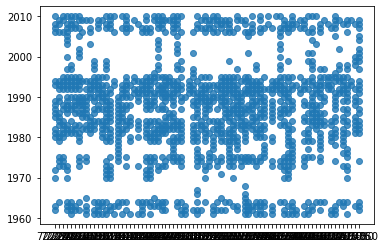

In [12]:
plt.scatter(siteyear.site, siteyear.year, alpha=0.8)

In [22]:
siteyear = siteyear.iloc[:10,:]

for i in np.arange(siteyear.shape[0]):
    # selecting site-year combinations
    site = siteyear.iloc[i,0]
    year = siteyear.iloc[i,1]
    print(site, year)
    
    # constructing dataframe that will hold all weather data
    col = ['jday','date','hour','solrad','temp','precip','rh', 'co2']
    df_wea = pd.DataFrame(columns=col)

    # setting up for time-relating entries
    times = pd.date_range(season_start + '-' + str(year), 
                          season_end + '-' + str(year)+ ' 23:00:00', freq='1H') # utc time
    zone = find_zone(site)
    local_datetime = utc_to_local(times, zone)

    # selecting weather data
    utc_start, utc_end = str(times[0]), str(times[-1])
    df_wea.temp = list(df_temp[utc_start:utc_end][site])
    df_wea.rh = list(np.round((df_rh[utc_start:utc_end][site])*100, 2))
    df_wea.precip = list(df_precip[utc_start:utc_end][site]/10) #*** this is a temporary fix for precip scaling bug
    df_wea.co2 = 400    

    # selecting solar radiation 
    t1 = pd.to_datetime(utc_start).to_pydatetime()
    t2 = pd.to_datetime(utc_end).to_pydatetime()
    tdiff = t2-t1
    local_start = str(local_datetime[0])[:19] 
    local_end = str(pd.to_datetime(local_start).to_pydatetime() + tdiff)[:19]
    df_wea.solrad = list(df_solrad[local_start:local_end][site])
    
    # adding time-relating info to data frame
    local = pd.date_range(local_start, local_end, freq='H')
    df_wea.jday = local.dayofyear
    df_wea.date = local.strftime("'%m/%d/%Y'")
    df_wea.hour = local.hour    
    
    df_wea.head()

722260 1962


NameError: name 'df_temp' is not defined